#### Import the Necessary Packages

In [1]:
import os
import sys
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Get the current working directory
current_folder = os.getcwd()

# # Add a relative path (e.g., parent folder or a specific subfolder)
SpeedNet_model_folder = os.path.abspath(os.path.join(current_folder, "../../SpeedNet_model"))
sys.path.append(SpeedNet_model_folder)

hsemetric_folder = os.path.abspath(os.path.join(current_folder, "../../HSEMETRIC"))
sys.path.append(hsemetric_folder)


# Now import the module
import SpeedNet_model_prep #(I created the package to allow easy flow extraction from the pretrained model)
import hsemetric        #(This package was created by Upendra et al. 2020)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from keras.models import load_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


#### Grad-Cam Heatmap Activation Function

In [3]:
def gradcamm(img_array, best_model):
    # First part
    last_conv_layer_name = "max_pooling2d_3"
    last_conv_layer = best_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(best_model.inputs, last_conv_layer.output)
    
    # Second part _ LSTM Regressor
    regression_layer_names = [
       "flatten",
       "reshape",
       "lstm",
       "dense",
       "dense_1"
    ]
    
    lstm_regressor_input = Input(shape=(14, 14, 128))
    x = lstm_regressor_input
    for layer_name in regression_layer_names:
        x = best_model.get_layer(layer_name)(x)
    regressor_model = Model(lstm_regressor_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        preds = regressor_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(128):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    heatmap = np.sum(last_conv_layer_output, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    resized_heatmap = cv2.resize(np.array(heatmap), (256,256))
    return resized_heatmap, preds
    

##### Evaluation Metrics

In [4]:
def rmse_corr_metrics(a_obs, b_preds):
    best_mae = mean_absolute_error(a_obs.dropna(), b_preds.dropna())
    best_mse = mean_squared_error(a_obs.dropna(), b_preds.dropna())
    best_rmse = root_mean_squared_error(a_obs.dropna(), b_preds.dropna())
    corr_matrix = np.corrcoef(a_obs.dropna(), b_preds.dropna())
    corr_coef = corr_matrix[0, 1]
    
    # Fisher transformation for uncertainty
    z = 0.5 * np.log((1 + corr_coef) / (1 - corr_coef))
    n = len(a_obs.dropna())
    se = 1 / np.sqrt(n - 3)
    z_conf_interval = se * 1.96  # 95% confidence interval
    pearson_conf_interval = 1.96 * (1 / np.sqrt(n - 3))
    pearson_uncertainty = np.tanh(z_conf_interval)
    
    # Uncertainty in MSE
    mse_uncertainty = np.sqrt(2 * best_mse ** 2 / n) 
    # Uncertainty in RMSE
    rmse_uncertainty = 0.5 * mse_uncertainty / best_rmse

    tp,fp,fn= hsemetric.BatchwiseHSE(np.array(a_obs.dropna()), np.array(b_preds.dropna()))
    threat_score=tp*1.0/(tp+fp+fn)
    print(f'TP: {tp} \nFP: {fp} \nFN: {fn}')
    return best_rmse, rmse_uncertainty, corr_coef, pearson_uncertainty, threat_score

#### Linear Fit

In [5]:
def linear_fit(df):
    """
    This function calculates the linear fit between the solar wind prediction and observed.
    and returns
    int{obs_cleaned}: The observed solar wind speed,
    int{pred_cleaned}: The predicted solar wind speed
    int{fitted_y}: The linear fit
    int{slope}: slope
    int{intercept} : intercept
    """
    df_cleaned = df.dropna()

    # Extract cleaned x and y
    obs_cleaned = df_cleaned["test_original"]
    pred_cleaned = df_cleaned["test_predicted"]
    slope, intercept = np.polyfit(obs_cleaned, pred_cleaned, 1)
    
    # Generate the fitted line
    fitted_y = slope * obs_cleaned + intercept

    return obs_cleaned, pred_cleaned, fitted_y, slope, intercept 

##### CSV FILE FUNCTION (FOR SAVING THE SW (Pred/Obs) from the Trained Model)

In [6]:
def save_data_csv(test_timestamps_output, test_velocity_out, best_pred, phase, fold_index, num_delay, n_steps=1):
    """
    test_timestamps_output: list of timestamp
    test_velocity_out: list of the original values
    best_pred: list of prediction
    phase: STRING --> solar cycle phase
    fold_index: cross-validation fold
    num_delay: data adapation delay; note that index starts from 0.
    n_steps: Default timesteps is equal to 1.
    """
    data_pred = {
            'date': test_timestamps_output[(n_steps-1):],
            'test_original': tf.squeeze(test_velocity_out[(n_steps-1):]),
            'test_predicted': tf.squeeze(best_pred)
        }
    pred_df = pd.DataFrame(data_pred)

    # Create a complete date range from the minimum to the maximum date in the data
    pred_date_range = pd.date_range(start=pred_df['date'].min(), end=pred_df['date'].max())

    # Reindex the DataFrame to insert NaN for missing dates
    pred_df = pred_df.set_index('date').reindex(pred_date_range).rename_axis('date').reset_index()

    pred_df.to_csv(f'{phase}_{fold_index}_and_delay_{num_delay+1}.csv', index=False)

### ASCENDING

In [ ]:
n_steps = 1
fold_index = 2
ascending_num_delay = 3
path = "/home/joseph/DL/DATASET"
train_start_date = "2010-05-13"
train_end_date = "2011-07-06"
test_start_date = "2011-07-07"
test_end_date = "2011-12-31"
img_train_path = "/home/joseph/DL/DATASET/ASCENDING_PHASE_COLORED/Train"
img_test_path = "/home/joseph/DL/DATASET/ASCENDING_PHASE_COLORED/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)


# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date, 
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
ascending_Train_image_cnn_date, ascending_Train_timeseries_date, ascending_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(ascending_num_delay,
                                                                                                                                              n_steps, map_train_non_icme_date,
                                                                                                                                              train_speed_dates, 
                                                                                                                                              solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
ascending_Test_image_cnn_date, ascending_Test_timeseries_date, ascending_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(ascending_num_delay,
                                                                                                                                           n_steps, map_test_non_icme_date,
                                                                                                                                           test_speed_dates,
                                                                                                                                           solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
ascending_train_velocity_out, ascending_test_velocity_out, ascending_test_timestamps_output = SpeedNet_model_prep.filter_output(df, ascending_Train_output_timeseries_date, ascending_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
ascending_train_images, ascending_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, ascending_Train_image_cnn_date, ascending_Test_image_cnn_date)

# Load the Pretrained Model
best_model_ascending = load_model(f"/home/joseph/DL/SpeedNet-EUV/ASCENDING/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{ascending_num_delay}.keras")

# Pretrained Model Prediction
best_pred_ascending = best_model_ascending.predict(ascending_test_images)

# Save the Prediction together with the Observation as CSV File
Ascending_save_to_csv = save_data_csv(ascending_test_timestamps_output, ascending_test_velocity_out, best_pred_ascending, "ASCENDING_PHASE", fold_index, ascending_num_delay, n_steps=1)
   

### MAXIMUM

In [ ]:
n_steps = 1
fold_index = 1
maximum_num_delay = 4
path = "/home/joseph/DL/DATASET"
train_start_date = "2012-01-01"
train_end_date = "2014-02-01"
test_start_date = "2014-02-02"
test_end_date = "2014-12-31"
img_train_path = "/home/joseph/DL/DATASET/MAXIMUM_PHASE_COLORED/Train"
img_test_path = "/home/joseph/DL/DATASET/MAXIMUM_PHASE_COLORED/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date, 
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)
# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
maximum_Train_image_cnn_date, maximum_Train_timeseries_date, maximum_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(maximum_num_delay,
                                                                                                                                        n_steps, map_train_non_icme_date,
                                                                                                                                        train_speed_dates, 
                                                                                                                                        solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
maximum_Test_image_cnn_date, maximum_Test_timeseries_date, maximum_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(maximum_num_delay,
                                                                                                                                     n_steps, map_test_non_icme_date,
                                                                                                                                     test_speed_dates, 
                                                                                                                                     solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
maximum_train_velocity_out, maximum_test_velocity_out, maximum_test_timestamps_output = SpeedNet_model_prep.filter_output(df, maximum_Train_output_timeseries_date, maximum_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
maximum_train_images, maximum_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, maximum_Train_image_cnn_date, maximum_Test_image_cnn_date)

# Load the Pretrained Model
best_model_maximum = load_model(f"/home/joseph/DL/SpeedNet-EUV/MAXIMUM/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{maximum_num_delay}.keras")

# Pretrained Model Prediction
best_pred_maximum = best_model_maximum.predict(maximum_test_images)

# Save the Prediction together with the Observation as CSV File
Maximum_save_to_csv = save_data_csv(maximum_test_timestamps_output, maximum_test_velocity_out, best_pred_maximum, "MAXIMUM_PHASE", fold_index, maximum_num_delay, n_steps=1)
  

### DECLINING

In [7]:
n_steps = 1
fold_index = 1
decline_num_delay = 4
path = "/home/joseph/DL/DATASET"
train_start_date = "2015-01-01"
train_end_date = "2017-12-31"
test_start_date = "2018-01-01"
test_end_date = "2018-12-31"
img_train_path = "/home/joseph/DL/DATASET/DECLINING_PHASE_COLORED/Train"
img_test_path = "/home/joseph/DL/DATASET/DECLINING_PHASE_COLORED/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path,img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
declining_Train_image_cnn_date, declining_Train_timeseries_date, declining_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(decline_num_delay,
                                                                                                                                              n_steps, map_train_non_icme_date, 
                                                                                                                                              train_speed_dates,
                                                                                                                                              solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
declining_Test_image_cnn_date, declining_Test_timeseries_date, declining_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(decline_num_delay,
                                                                                                                                           n_steps, map_test_non_icme_date,
                                                                                                                                           test_speed_dates,
                                                                                                                                           solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
declining_train_velocity_out, declining_test_velocity_out, declining_test_timestamps_output = SpeedNet_model_prep.filter_output(df, declining_Train_output_timeseries_date, declining_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
declining_train_images, declining_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, declining_Train_image_cnn_date, declining_Test_image_cnn_date)

# Load the Pretrained Model
best_model_declining = load_model(f"/home/joseph/DL/SpeedNet-EUV/DECLINING/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{decline_num_delay}.keras")

# Pretrained Model Prediction
best_pred_declining = best_model_declining.predict(declining_test_images)

# Save the Prediction together with the Observation as CSV File
declining_save_to_csv = save_data_csv(declining_test_timestamps_output, declining_test_velocity_out, best_pred_declining, "DECLINING_PHASE", fold_index, decline_num_delay, n_steps=1)


### MINIMUM

In [9]:
n_steps = 1
fold_index = 1
Minimum_num_delay = 4
path = "/home/joseph/DL/DATASET"
train_start_date = "2019-01-01"
train_end_date = "2020-05-26"
test_start_date = "2020-05-27"
test_end_date = "2020-12-31"
img_train_path = "/home/joseph/DL/DATASET/MINIMUM_PHASE_COLORED/Train"
img_test_path = "/home/joseph/DL/DATASET/MINIMUM_PHASE_COLORED/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
Minimum_Train_image_cnn_date, Minimum_Train_timeseries_date, Minimum_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(Minimum_num_delay,
                                                                                                                                        n_steps, map_train_non_icme_date,
                                                                                                                                        train_speed_dates,
                                                                                                                                        solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
Minimum_Test_image_cnn_date, Minimum_Test_timeseries_date, Minimum_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(Minimum_num_delay,
                                                                                                                                     n_steps, map_test_non_icme_date,
                                                                                                                                     test_speed_dates,
                                                                                                                                     solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
Minimum_train_velocity_out, Minimum_test_velocity_out, Minimum_test_timestamps_output = SpeedNet_model_prep.filter_output(df, Minimum_Train_output_timeseries_date, Minimum_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
Minimum_train_images, Minimum_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, Minimum_Train_image_cnn_date, Minimum_Test_image_cnn_date)

# Load the Pretrained Model
best_model_Minimum = load_model(f"/home/joseph/DL/SpeedNet-EUV/MINIMUM/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{Minimum_num_delay}.keras")

# Pretrained Model Prediction
best_pred_Minimum = best_model_Minimum.predict(Minimum_test_images)

# Save the Prediction together with the Observation as CSV File
Minimum_save_to_csv = save_data_csv(Minimum_test_timestamps_output, Minimum_test_velocity_out, best_pred_Minimum, "MINIMUM_PHASE", fold_index, Minimum_num_delay, n_steps=1)


### Further Prep

In [15]:
### Visualizing the Best predicition (Uniform across all cases.)

# 1. Ascending Indexing
ascending_max = np.argmax(ascending_test_velocity_out)
ascending_min = np.argmin(ascending_test_velocity_out)
ascending_indices_rand = [ascending_max-1, ascending_max, ascending_max+1, ascending_min, ascending_min+1]

# Ascending Image Selection based on the Above indexing
ascending_random_selection = ascending_test_images[ascending_indices_rand]
# Ascending Observed SW speed based on the Above indexing
ascending_orig_value = ascending_test_velocity_out[ascending_indices_rand]
# Ascending Timestamp based on the Above indexing
ascending_test_plot_date = pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]]).date[0]

# 2. Maximum Indexing
Maximum_max = np.argmax(maximum_test_velocity_out)
Maximum_min = np.argmin(maximum_test_velocity_out)
Maximum_indices_rand = [Maximum_max-1, Maximum_max, Maximum_max+1, Maximum_min, Maximum_min+1]

# Maximum Image Selection based on the Above indexing
maximum_random_selection = maximum_test_images[Maximum_indices_rand]
# Maximum Observed SW speed based on the Above indexing
maximum_orig_value = maximum_test_velocity_out[Maximum_indices_rand]
# Maximum Timestamp based on the Above indexing
maximum_test_plot_date = pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]]).date[0]

# 3. Declining Indexing
declining_n = 30
declining_sub_array = declining_test_velocity_out[-declining_n:]
declining_relative_index = np.argmax(declining_sub_array)
declining_max = len(declining_test_velocity_out) - declining_n + declining_relative_index
declining_min = np.argmin(declining_test_velocity_out)
declining_indices_rand = [declining_max-1, declining_max, declining_max+1, declining_min, declining_min+1]

# Declining Image Selection based on the Above indexing
declining_random_selection = declining_test_images[declining_indices_rand]
# Declining Observed SW speed based on the Above indexing
declining_orig_value = declining_test_velocity_out[declining_indices_rand]
# Declining Timestamp based on the Above indexing
declining_test_plot_date = pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]]).date[0]

# 4. Minimum Indexing
minimum_n = 70
minimum_sub_array = Minimum_test_velocity_out[-minimum_n:-50]
minimum_relative_index = np.argmax(minimum_sub_array)
Minimum_max = len(Minimum_test_velocity_out) - minimum_n + minimum_relative_index
Minimum_min = np.argmin(Minimum_test_velocity_out)
Minimum_indices_rand = [Minimum_max-1, Minimum_max, Minimum_max+1, Minimum_min, Minimum_min+1]

# Minimum Image Selection based on the Above indexing
minimum_random_selection = Minimum_test_images[Minimum_indices_rand]
# Minimum Observed SW speed based on the Above indexing
minimum_orig_value = Minimum_test_velocity_out[Minimum_indices_rand]
# Minimum Timestamp based on the Above indexing
minimum_test_plot_date = pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]]).date[0]

### GRAD-Cam Activation across different SC Phases

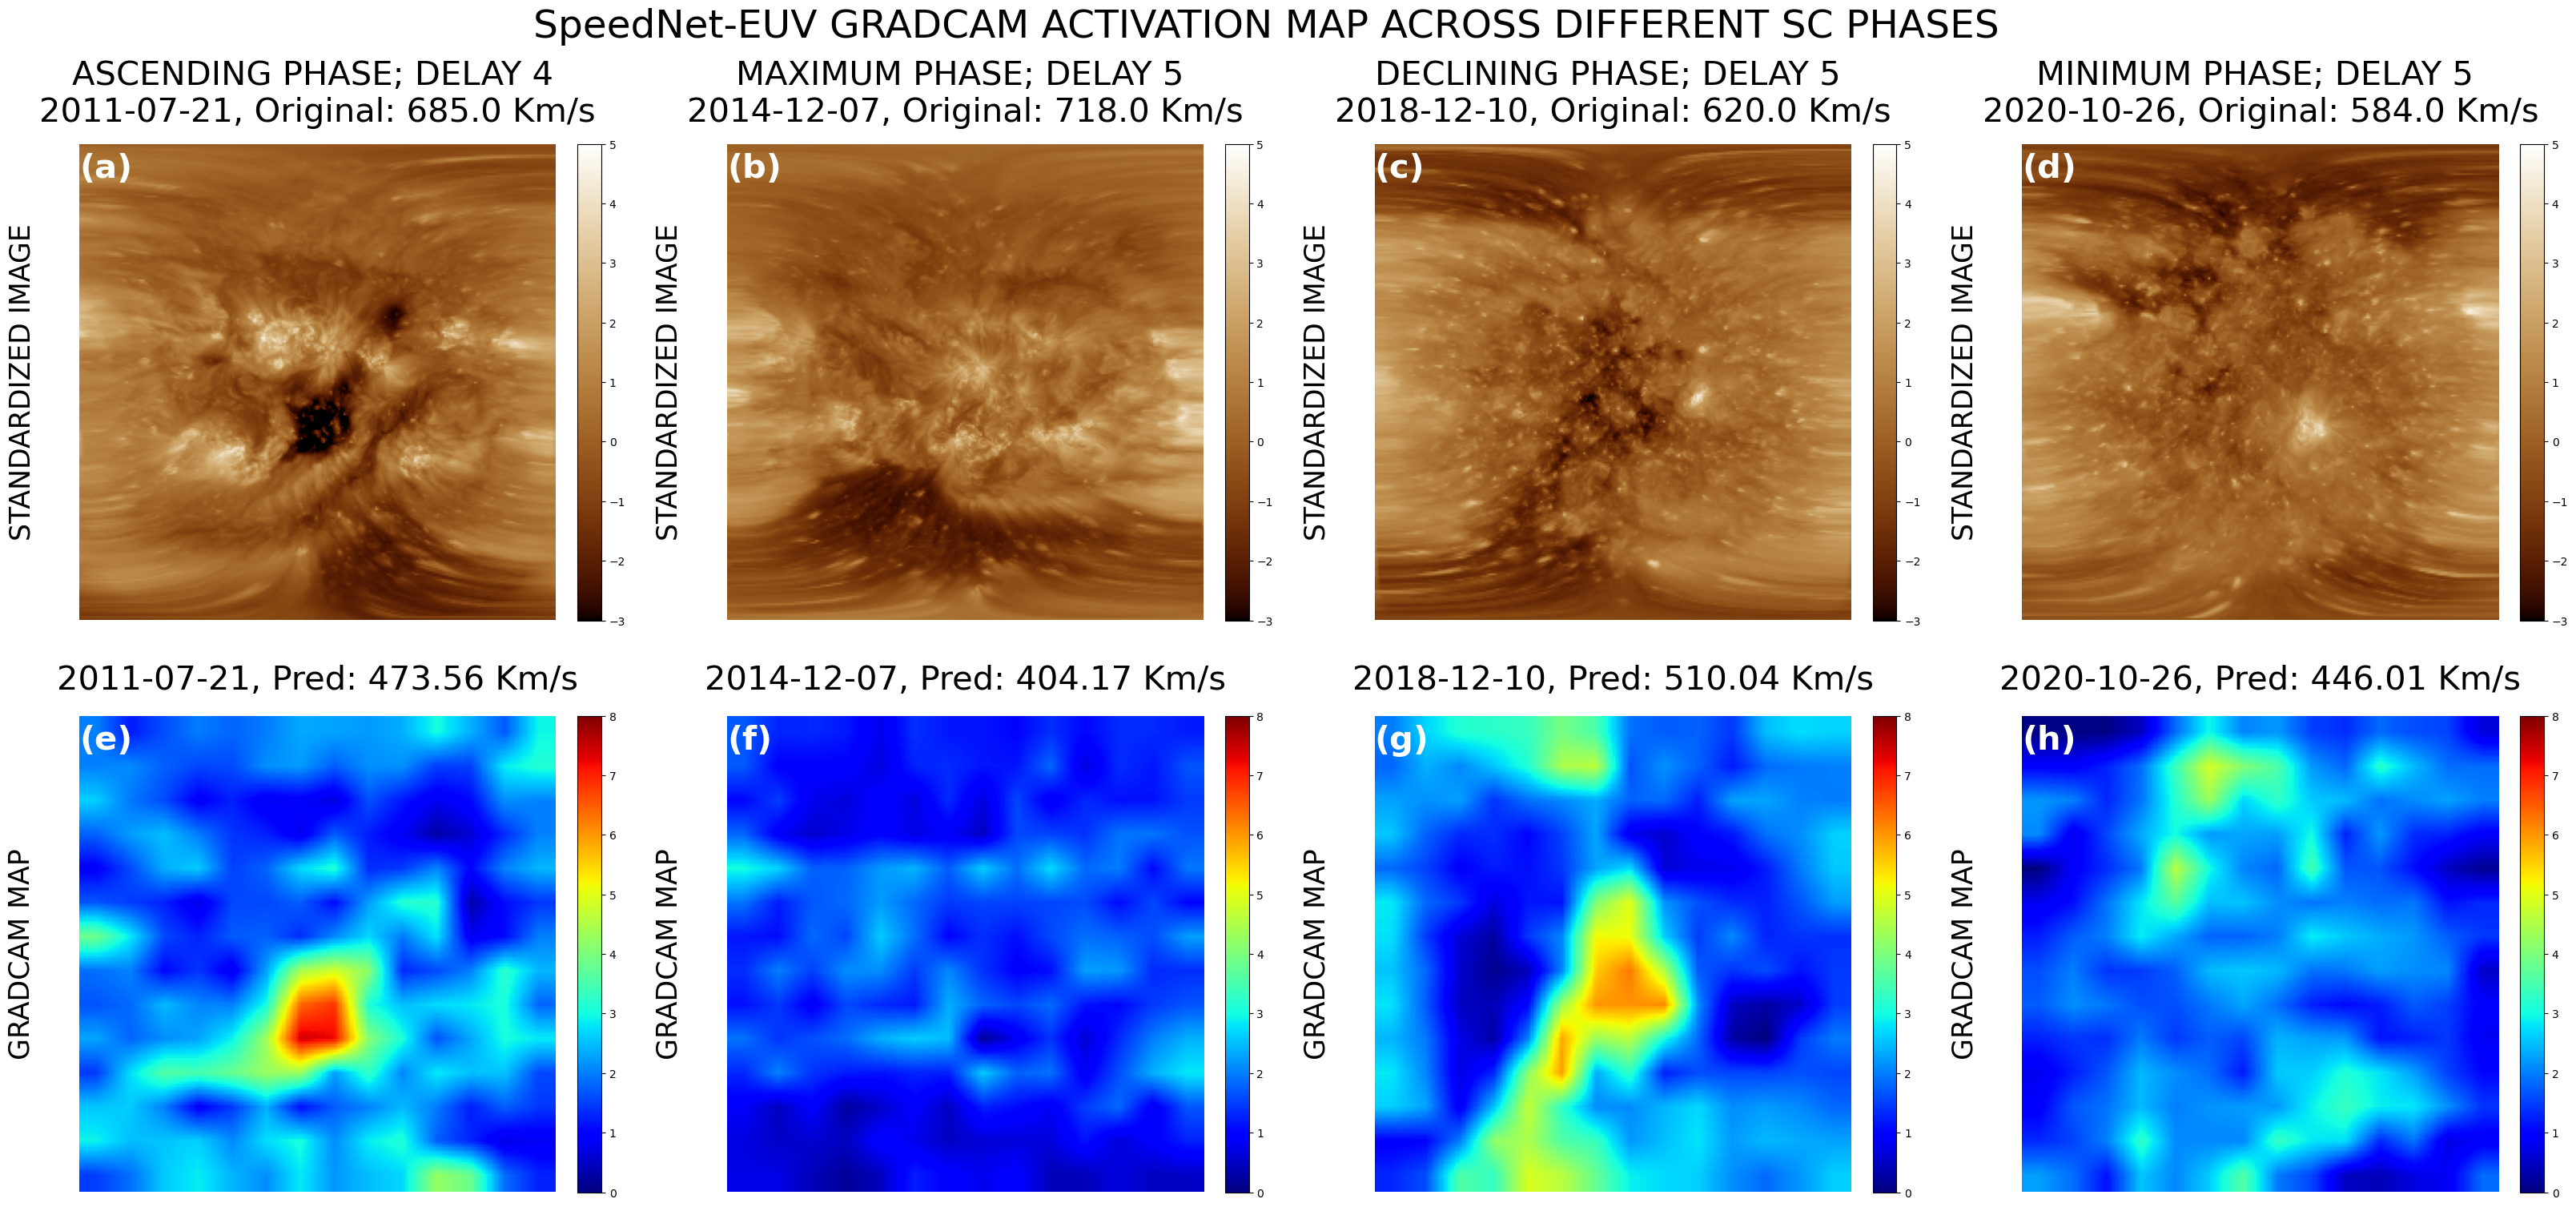

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(40, 17))
fig.suptitle(f"SpeedNet-EUV GRADCAM ACTIVATION MAP ACROSS DIFFERENT SC PHASES", fontsize=35)

plt.style.use("default")

ascend_real = axs[0, 0].imshow(ascending_random_selection[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(ascend_real ,ax=axs[0, 0], fraction=0.05, pad=0.04)
axs[0, 0].set_title(f'ASCENDING PHASE; DELAY {ascending_num_delay+1} \n{pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]+(ascending_num_delay+1)]).date[0]}, Original: {tf.squeeze(ascending_orig_value[1])} Km/s', fontsize=30, pad=20)
axs[0, 0].set_xlabel(f'Longitude [deg]')
axs[0, 0].set_ylabel(f'Latitude [deg]')
axs[0, 0].axis('off')
axs[0, 0].set_label('Intensity')
axs[0, 0].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=25, rotation=90, transform=axs[0, 0].transAxes, va='center')
axs[0, 0].text(0, 0.93, '(a)', fontsize=30, fontweight='bold', transform=axs[0, 0].transAxes, color='white')

maximum_real = axs[0, 1].imshow(maximum_random_selection[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(maximum_real ,ax=axs[0, 1], fraction=0.05, pad=0.04)
axs[0, 1].set_title(f'MAXIMUM PHASE; DELAY {maximum_num_delay+1} \n{pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]+(maximum_num_delay+1)]).date[0]}, Original: {tf.squeeze(maximum_orig_value[1])} Km/s', fontsize=30, pad=20)
axs[0, 1].set_xlabel(f'Longitude [deg]')
axs[0, 1].set_ylabel(f'Latitude [deg]')
axs[0, 1].axis('off')
axs[0, 1].set_label('Intensity')
axs[0, 1].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=25, rotation=90, transform=axs[0, 1].transAxes, va='center')
axs[0, 1].text(0, 0.93, '(b)', fontsize=30, fontweight='bold', transform=axs[0, 1].transAxes, color='white')


decline_real = axs[0, 2].imshow(declining_random_selection[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(decline_real ,ax=axs[0, 2], fraction=0.05, pad=0.04)
axs[0, 2].set_title(f'DECLINING PHASE; DELAY {decline_num_delay+1} \n{pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]+(decline_num_delay+1)]).date[0]}, Original: {tf.squeeze(declining_orig_value[1])} Km/s', fontsize=30, pad=20)
axs[0, 2].set_xlabel(f'Longitude [deg]')
axs[0, 2].set_ylabel(f'Latitude [deg]')
axs[0, 2].axis('off')
axs[0, 2].set_label('Intensity')
axs[0, 2].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=25, rotation=90, transform=axs[0, 2].transAxes, va='center')
axs[0, 2].text(0, 0.93, '(c)', fontsize=30, fontweight='bold', transform=axs[0, 2].transAxes, color='white')
   
minimum_real = axs[0, 3].imshow(minimum_random_selection[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(minimum_real ,ax=axs[0, 3], fraction=0.05, pad=0.04)
axs[0, 3].set_title(f'MINIMUM PHASE; DELAY {Minimum_num_delay+1} \n{pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]+(Minimum_num_delay+1)]).date[0]}, Original: {tf.squeeze(minimum_orig_value[1])} Km/s', fontsize=30, pad=20)
axs[0, 3].set_xlabel(f'Longitude [deg]')
axs[0, 3].set_ylabel(f'Latitude [deg]')
axs[0, 3].axis('off')
axs[0, 3].set_label('Intensity')
axs[0, 3].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=25, rotation=90, transform=axs[0, 3].transAxes, va='center')
axs[0, 3].text(0, 0.93, '(d)', fontsize=30, fontweight='bold', transform=axs[0, 3].transAxes, color='white')

     
ascend_img_cam, ascend_value = gradcamm(ascending_random_selection[1].reshape(1,256, 256, 3), best_model_ascending)
ascending_grad_cam = axs[1, 0].matshow(ascend_img_cam, cmap='jet', vmin=0, vmax=8)
fig.colorbar(ascending_grad_cam ,ax=axs[1, 0], fraction=0.05, pad=0.04)
axs[1, 0].axis('off') 
axs[1, 0].set_label('Intensity')
axs[1, 0].set_title(f'{pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]+(ascending_num_delay+1)]).date[0]}, Pred: {tf.squeeze(ascend_value):.2f} Km/s', fontsize=30)
axs[1, 0].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=25, rotation=90, transform=axs[1, 0].transAxes, va='center')
axs[1, 0].text(0, 0.93, '(e)', fontsize=30, fontweight='bold', transform=axs[1, 0].transAxes, color='white')

maximum_img_cam, maximum_value = gradcamm(maximum_random_selection[1].reshape(1,256, 256, 3), best_model_maximum)
maximum_grad_cam = axs[1, 1].matshow(maximum_img_cam, cmap='jet', vmin=0, vmax=8)
fig.colorbar(maximum_grad_cam ,ax=axs[1, 1], fraction=0.05, pad=0.04)
axs[1, 1].axis('off') 
axs[1, 1].set_label('Intensity')
axs[1, 1].set_title(f'{pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]+(maximum_num_delay+1)]).date[0]}, Pred: {tf.squeeze(maximum_value):.2f} Km/s', fontsize=30)
axs[1, 1].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=25, rotation=90, transform=axs[1, 1].transAxes, va='center')
axs[1, 1].text(0, 0.93, '(f)', fontsize=30, fontweight='bold', transform=axs[1, 1].transAxes, color='white')

decline_img_cam, decline_value = gradcamm(declining_random_selection[1].reshape(1,256, 256, 3), best_model_declining)
decline_grad_cam = axs[1, 2].matshow(decline_img_cam, cmap='jet', vmin=0, vmax=8)
fig.colorbar(decline_grad_cam ,ax=axs[1, 2], fraction=0.05, pad=0.04)
axs[1, 2].axis('off') 
axs[1, 2].set_label('Intensity')
axs[1, 2].set_title(f'{pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]+(decline_num_delay+1)]).date[0]}, Pred: {tf.squeeze(decline_value):.2f} Km/s', fontsize=30)
axs[1, 2].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=25, rotation=90, transform=axs[1, 2].transAxes, va='center')
axs[1, 2].text(0, 0.93, '(g)', fontsize=30, fontweight='bold', transform=axs[1, 2].transAxes, color='white')

minimum_img_cam, minimum_value = gradcamm(minimum_random_selection[1].reshape(1,256, 256, 3), best_model_Minimum)
minimum_grad_cam = axs[1, 3].matshow(minimum_img_cam, cmap='jet', vmin=0, vmax=8)
fig.colorbar(minimum_grad_cam ,ax=axs[1, 3], fraction=0.05, pad=0.04)
axs[1, 3].axis('off') 
axs[1, 3].set_label('Intensity')
axs[1, 3].set_title(f'{pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]+(Minimum_num_delay+1)]).date[0]}, Pred: {tf.squeeze(minimum_value):.2f} Km/s', fontsize=30)
axs[1, 3].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=25, rotation=90, transform=axs[1, 3].transAxes, va='center')
axs[1, 3].text(0, 0.93, '(h)', fontsize=30, fontweight='bold', transform=axs[1, 3].transAxes, color='white') 
# plt.tight_layout()
# plt.subplots_adjust(top=0.95, hspace=0.3)
plt.savefig(f"Summarized_channel_windnet_gradcam_b.png")
plt.show()

### FULL SC PERIOD

In [20]:
n_steps = 1
fold_index = 1
full_period_num_delay = 4
path = "/home/joseph/DL/DATASET"
train_start_date = "2010-05-13"
train_end_date = "2018-12-31"
test_start_date = "2019-01-01"
test_end_date = "2019-12-31"
img_train_path = "/home/joseph/DL/DATASET/FULL_CYCLE_CHANNEL_256/Train"
img_test_path = "/home/joseph/DL/DATASET/FULL_CYCLE_CHANNEL_256/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
full_period_Train_image_cnn_date, full_period_Train_timeseries_date, full_period_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(full_period_num_delay,
                                                                                                                                                    n_steps, map_train_non_icme_date, 
                                                                                                                                                    train_speed_dates, 
                                                                                                                                                    solar_image_train_indices, Speed_train_indices)    
# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
full_period_Test_image_cnn_date, full_period_Test_timeseries_date, full_period_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(full_period_num_delay,
                                                                                                                                                 n_steps, map_test_non_icme_date,
                                                                                                                                                 test_speed_dates,
                                                                                                                                                 solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
full_period_train_velocity_out, full_period_test_velocity_out, full_period_test_timestamps_output = SpeedNet_model_prep.filter_output(df, full_period_Train_output_timeseries_date, full_period_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
full_period_train_images, full_period_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, full_period_Train_image_cnn_date,full_period_Test_image_cnn_date)

# Load the Pretrained Model
best_model_full_period = load_model(f"/home/joseph/DL/SpeedNet-EUV/FULL_CYCLE/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{full_period_num_delay}.keras")

# Pretrained Model Prediction
best_pred_full_period = best_model_full_period.predict(full_period_test_images)

# Save the Prediction together with the Observation as CSV File
full_cycle_save_to_csv = save_data_csv(full_period_test_timestamps_output, full_period_test_velocity_out, best_pred_full_period, "FULL_CYCLE", fold_index, full_period_num_delay, n_steps=1)


## HSS Period

In [22]:
### Obtain the Peak 
full_period_max = np.argmax(full_period_test_velocity_out)

# Two days before the HSS peak and two days after the peak
HSS_full_period_indices_rand = [full_period_max-2, full_period_max-1, full_period_max, full_period_max+1, full_period_max+2]

# Four days before the HSS peak and Four days after the peak
longer_HSS_full_period_indices_rand = [full_period_max-4, full_period_max-3, full_period_max-2, full_period_max-1, full_period_max, full_period_max+1, full_period_max+2, full_period_max+3, full_period_max+4]



In [23]:
### EUV-MAP during the Period (Two days before/after)
HSS_full_period_selection = full_period_test_images[HSS_full_period_indices_rand]

### Observed Solar wind speed during the Period (Two days before/after)
HSS_full_period_orig_value = full_period_test_velocity_out[HSS_full_period_indices_rand]
### DATE during the Period (Two days before/after)
HSS_full_period_test_plot_date = pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[1]]).date[0]


### EUV-MAP during the Period (Four days before/after)
Longer_HSS_full_period_selection = full_period_test_images[longer_HSS_full_period_indices_rand]

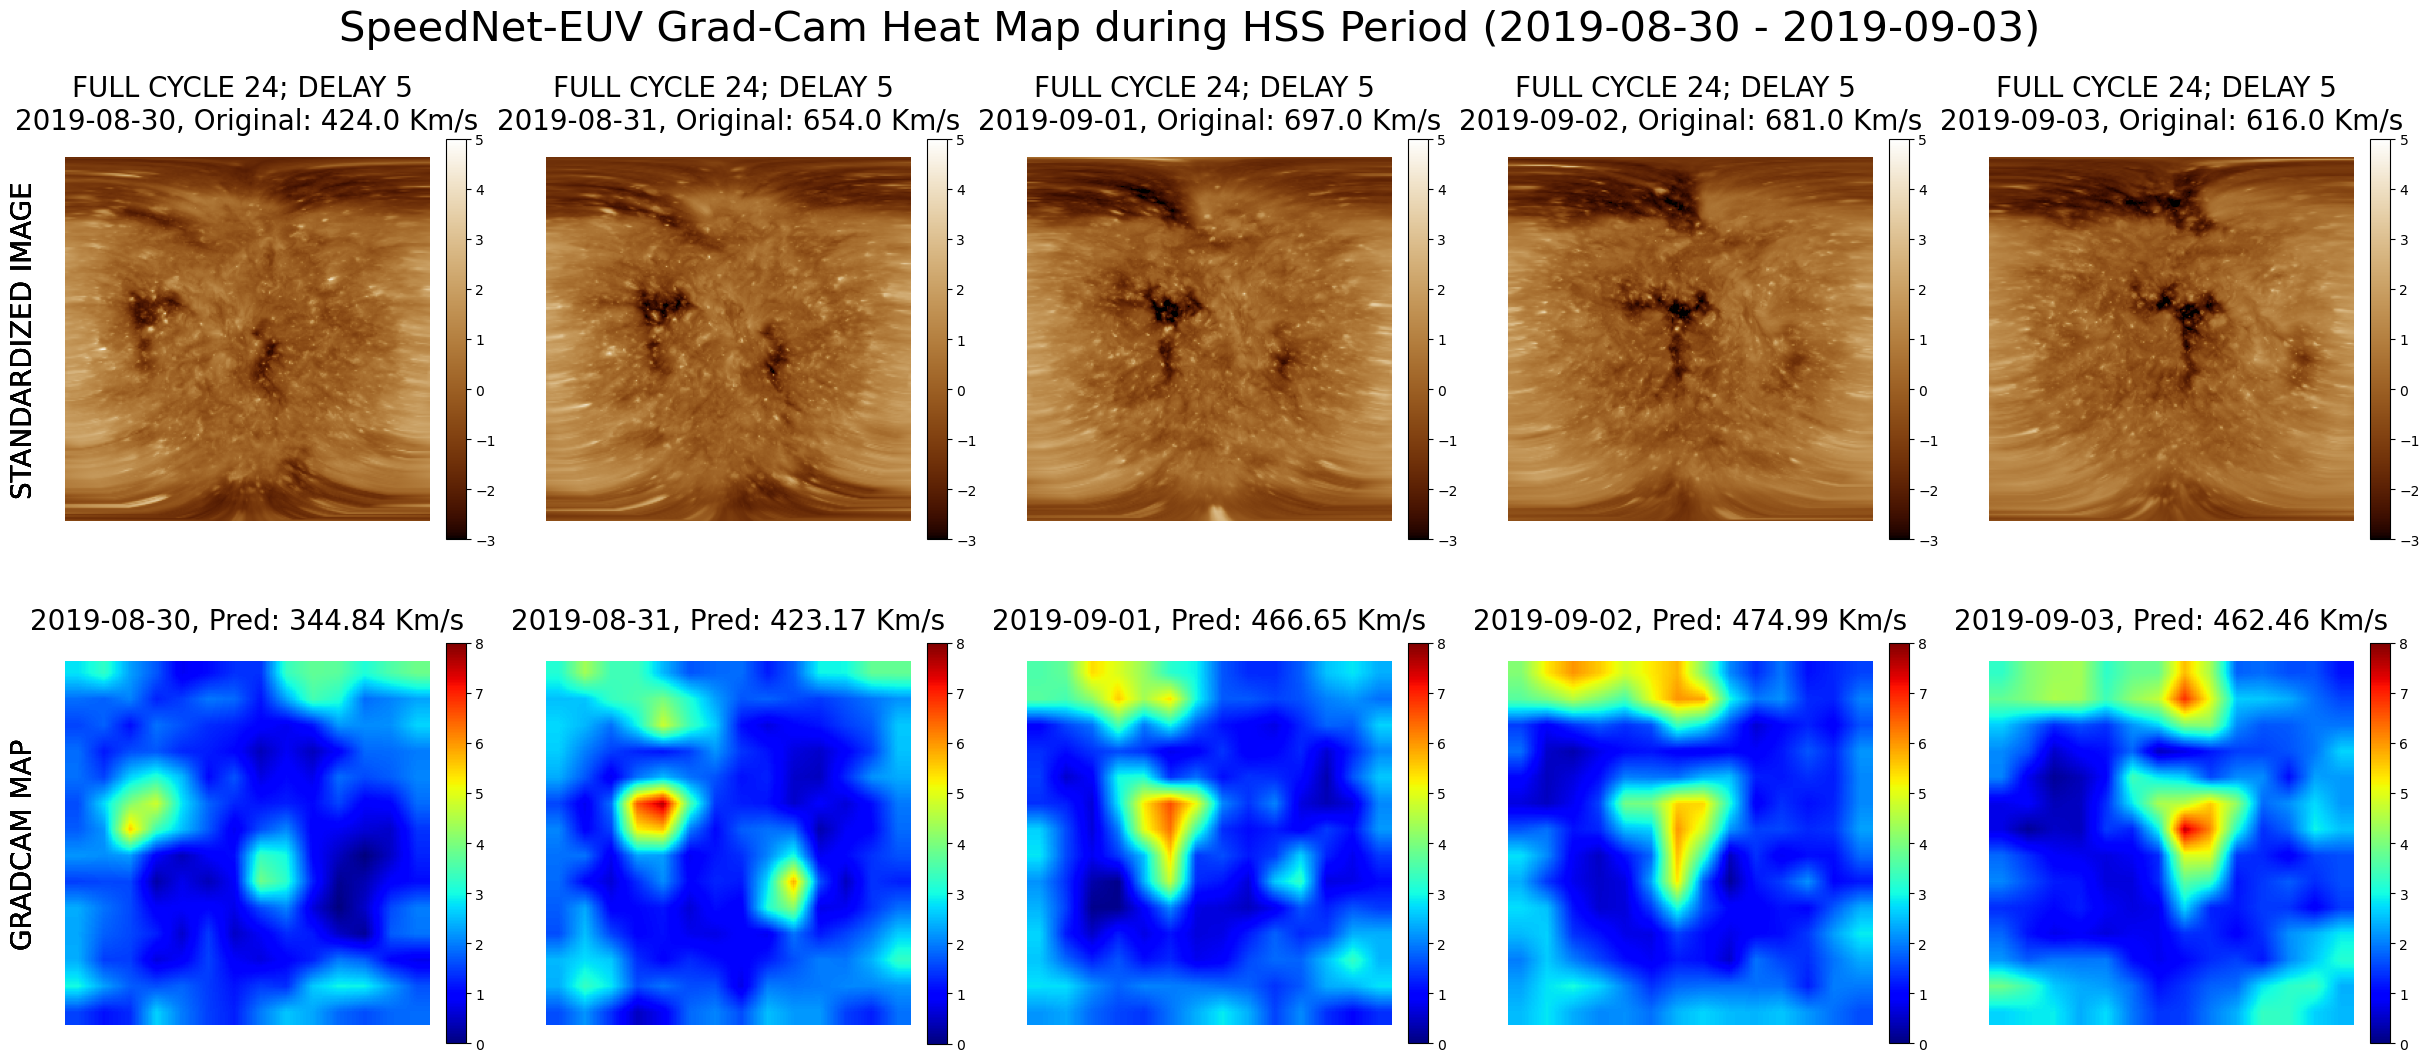

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(30, 12))
fig.suptitle(f"SpeedNet-EUV Grad-Cam Heat Map during HSS Period ({pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[0]+(full_period_num_delay+1)]).strftime('%Y-%m-%d')[0]} - {pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[-1]+(full_period_num_delay+1)]).strftime('%Y-%m-%d')[0]})" , fontsize=30)
plt.style.use("default")

for i in range(len(HSS_full_period_indices_rand)):
    
    HSS_full_period_real = axs[0, i].imshow(HSS_full_period_selection[i][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
    fig.colorbar(HSS_full_period_real ,ax=axs[0, i], fraction=0.05, pad=0.04)
    axs[0, i].set_title(f'FULL CYCLE 24; DELAY {full_period_num_delay+1} \n{pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[i]+(full_period_num_delay+1)]).date[0]}, Original: {tf.squeeze(HSS_full_period_orig_value[i])} Km/s', fontsize=20, pad=20)
    axs[0, i].set_xlabel(f'Longitude [deg]')
    axs[0, i].set_ylabel(f'Latitude [deg]')
    axs[0, i].axis('off')
    axs[0, i].set_label('Intensity')
    axs[0, 0].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=20, rotation=90, transform=axs[0, 0].transAxes, va='center')
    
    HSS_full_period_img_cam, HSS_full_period_value = gradcamm(HSS_full_period_selection[i].reshape(1,256, 256, 3), best_model_full_period)
    HSS_full_period_grad_cam = axs[1, i].matshow(HSS_full_period_img_cam, cmap='jet', vmin=0, vmax=8)
    fig.colorbar(HSS_full_period_grad_cam ,ax=axs[1, i], fraction=0.05, pad=0.04)
    axs[1, i].axis('off') 
    axs[1, i].set_label('Intensity')
    axs[1, i].set_title(f'{pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[i]+(full_period_num_delay+1)]).date[0]}, Pred: {tf.squeeze(HSS_full_period_value):.2f} Km/s', fontsize=20)
    axs[1, 0].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=20, rotation=90, transform=axs[1, 0].transAxes, va='center')
    
    
# plt.subplots_adjust(top=0.95, hspace=0.5)
plt.savefig(f"HSS_GRADCAM_ACROSS_FULL_CYCLE.png")
plt.show()
    

### PLOT THE TIMESERIES DATA

In [25]:
Ascending_case_1 = pd.read_csv("ASCENDING_PHASE_2_and_delay_4.csv")
Ascending_case_1["date"]=pd.to_datetime(Ascending_case_1["date"], format="mixed")
Ascending_case_1.set_index(Ascending_case_1["date"], inplace=True)
Ascending_case_1.head()

date  test_original  test_predicted
date                                                
2011-07-12 2011-07-12          681.0       397.12424
2011-07-13 2011-07-13          538.0       385.87213
2011-07-14 2011-07-14          493.0       392.56763
2011-07-15 2011-07-15            NaN             NaN
2011-07-16 2011-07-16            NaN             NaN

In [26]:
Maximum_case_1 = pd.read_csv("MAXIMUM_PHASE_1_and_delay_5.csv")
Maximum_case_1["date"]=pd.to_datetime(Maximum_case_1["date"], format="mixed")
Maximum_case_1.set_index(Maximum_case_1["date"], inplace=True)
Maximum_case_1.head()

date  test_original  test_predicted
date                                                
2014-02-28 2014-02-28          428.0       374.05870
2014-03-01 2014-03-01          393.0       353.55737
2014-03-02 2014-03-02          372.0       355.30948
2014-03-03 2014-03-03          346.0       353.12997
2014-03-04 2014-03-04          370.0       320.43990

In [27]:
Declining_case_1 = pd.read_csv("DECLINING_PHASE_1_and_delay_5.csv")
Declining_case_1["date"]=pd.to_datetime(Declining_case_1["date"], format="mixed")
Declining_case_1.set_index(Declining_case_1["date"], inplace=True)
Declining_case_1.head()

date  test_original  test_predicted
date                                                
2018-01-06 2018-01-06          305.0       309.48898
2018-01-07 2018-01-07          289.0       309.75540
2018-01-08 2018-01-08          387.0       332.04752
2018-01-09 2018-01-09          503.0       410.56790
2018-01-10 2018-01-10          440.0       375.85443

In [28]:
Minimum_case_1 = pd.read_csv("MINIMUM_PHASE_1_and_delay_5.csv")
Minimum_case_1["date"]=pd.to_datetime(Minimum_case_1["date"], format="mixed")
Minimum_case_1.set_index(Minimum_case_1["date"], inplace=True)
Minimum_case_1.head()

date  test_original  test_predicted
date                                                
2020-06-01 2020-06-01          378.0       391.24484
2020-06-02 2020-06-02          343.0       383.90036
2020-06-03 2020-06-03          326.0       398.95917
2020-06-04 2020-06-04          319.0       364.96704
2020-06-05 2020-06-05          326.0       347.97244

In [29]:
full_cycle_period_case_1 =  pd.read_csv("FULL_CYCLE_1_and_delay_5.csv")
full_cycle_period_case_1["date"]=pd.to_datetime(full_cycle_period_case_1["date"], format="mixed")
full_cycle_period_case_1.set_index(full_cycle_period_case_1["date"], inplace=True)
full_cycle_period_case_1.head()

date  test_original  test_predicted
date                                                
2019-01-06 2019-01-06          523.0       452.07938
2019-01-07 2019-01-07          497.0       447.10297
2019-01-08 2019-01-08          431.0       393.76135
2019-01-09 2019-01-09          418.0       350.74600
2019-01-10 2019-01-10          379.0       360.46643

In [30]:
print("Ascending Phase")
Ascen_best_rmse_case_1, Ascen_rmse_uncertainty_case_1, Ascen_corr_coef_case_1, Ascen_pearson_uncertainty_case_1, Ascen_threat_score_case_1= rmse_corr_metrics(Ascending_case_1["test_original"],Ascending_case_1["test_predicted"])
print("Maximum Phase")
Maxi_best_rmse_case_1, Maxi_rmse_uncertainty_case_1, Maxi_corr_coef_case_1, Maxi_pearson_uncertainty_case_1, Maxi_threat_score_case_1 = rmse_corr_metrics(Maximum_case_1["test_original"], Maximum_case_1["test_predicted"])
print("Declining Phase")
Decl_best_rmse_case_1, Decl_rmse_uncertainty_case_1, Decl_corr_coef_case_1, Decl_pearson_uncertainty_case_1, Decl_threat_score_case_1 = rmse_corr_metrics(Declining_case_1["test_original"], Declining_case_1["test_predicted"])
print("Minimum Phase")
Mini_best_rmse_case_1, Mini_rmse_uncertainty_case_1, Mini_corr_coef_case_1, Mini_pearson_uncertainty_case_1, Mini_threat_score_case_1 = rmse_corr_metrics(Minimum_case_1["test_original"], Minimum_case_1["test_predicted"])
print("Full SC Phase")
full_best_rmse_2019_case_1, full_rmse_uncertainty_2019_case_1, full_corr_coef_2019_case_1, full_pearson_uncertainty_2019_case_1, full_2019_threat_score_case_1 = rmse_corr_metrics(full_cycle_period_case_1["test_original"], full_cycle_period_case_1["test_predicted"])

Ascending Phase
TP: 0 
FP: 1 
FN: 7
Maximum Phase
TP: 0 
FP: 3 
FN: 12
Declining Phase
TP: 13 
FP: 3 
FN: 16
Minimum Phase
TP: 0 
FP: 0 
FN: 10
Full SC Phase
TP: 3 
FP: 0 
FN: 16


#### Temporal variation of the timeseries acrooss SC phases

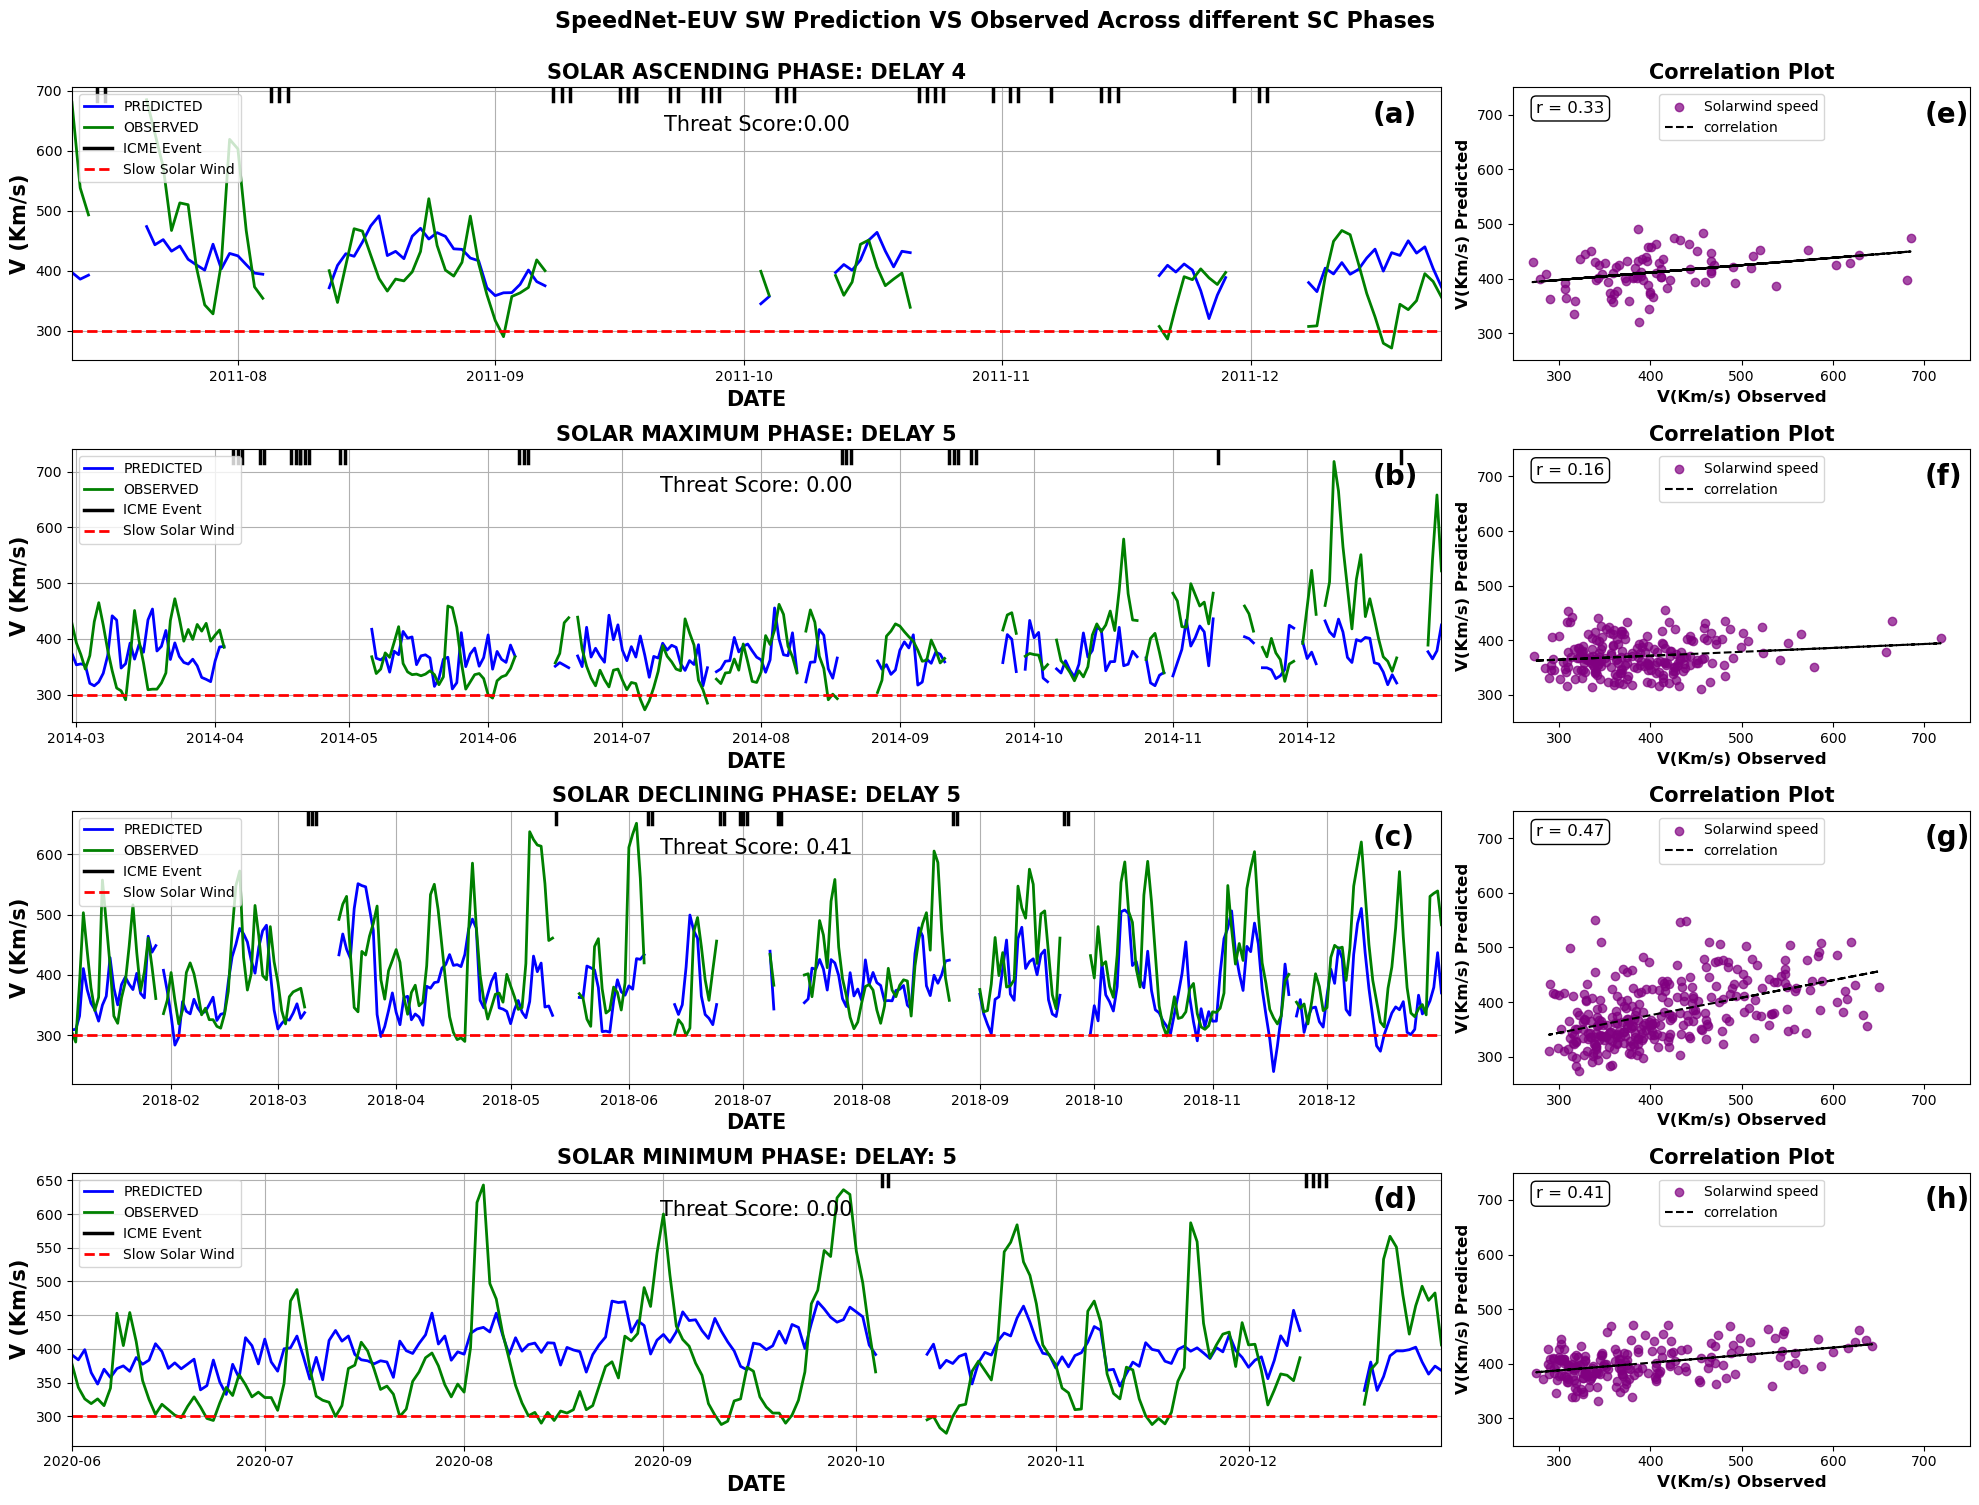

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(20,15), gridspec_kw={'width_ratios': [3, 1]})
# fig.tight_layout(pad=4.0)
plt.plot()
plt.style.use('default')

fig.suptitle(f"SpeedNet-EUV SW Prediction VS Observed Across different SC Phases", fontsize = 16, fontweight = "bold", y=1.0);

# ASCENDING PHASE 
ax[0,0].plot(Ascending_case_1['date'],Ascending_case_1["test_predicted"], linestyle='-', color='b', linewidth=2, label= 'PREDICTED')
ax[0,0].plot(Ascending_case_1['date'],Ascending_case_1["test_original"], linestyle='-', color='g', linewidth=2, label= 'OBSERVED')

for i, icme_date in enumerate(full_icme_list):
    ax[0,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[0,0].set_title(f'SOLAR ASCENDING PHASE: DELAY {ascending_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[0,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[0,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[0,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[0,0].text(0.5, 0.9, f'Threat Score:{Ascen_threat_score_case_1:.2f}', transform=ax[0,0].transAxes, fontsize=15, va='top', ha='center')
ax[0,0].text(0.95, 0.95, '(a)', transform=ax[0,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0,0].grid("on")
ax[0,0].set_xlim(Ascending_case_1['date'].iloc[0], Ascending_case_1['date'].iloc[-1])
ax[0,0].legend(loc='upper left')

# Correlation plot in the Ascending Phase
ax[0, 1].scatter(Ascending_case_1["test_original"], Ascending_case_1["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_ascending_case_1, pred_cleaned_ascending_case_1, fitted_y_ascending_case_1, slope_ascending_case_1, intercept_ascending_case_1 = linear_fit(Ascending_case_1)
ax[0, 1].plot(obs_cleaned_ascending_case_1, fitted_y_ascending_case_1, color='black', linestyle='--', label="correlation")
ax[0, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[0, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[0, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[0, 1].text(0.05, 0.95, f"r = {Ascen_corr_coef_case_1:.2f}", transform=ax[0, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[0,1].text(0.9, 0.95, '(e)', transform=ax[0,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0, 1].set_xlim(250, 750)
ax[0, 1].set_ylim(250, 750)
ax[0, 1].legend(loc='upper center')

# MAXIMUM PHASE
ax[1,0].plot(Maximum_case_1['date'],Maximum_case_1["test_predicted"],  linestyle='-', color='b', linewidth=2, label='PREDICTED')
ax[1,0].plot(Maximum_case_1['date'],Maximum_case_1["test_original"],  linestyle='-', color='g', linewidth=2, label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[1,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[1,0].set_title(f'SOLAR MAXIMUM PHASE: DELAY {maximum_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[1,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[1,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[1,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[1,0].grid("on")
ax[1,0].text(0.5, 0.9, f'Threat Score: {Maxi_threat_score_case_1:.2f}', transform=ax[1,0].transAxes, fontsize=15,va='top', ha='center')
ax[1,0].text(0.95, 0.95, '(b)', transform=ax[1,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1,0].set_xlim(Maximum_case_1['date'].iloc[0], Maximum_case_1['date'].iloc[-1])
ax[1,0].legend(loc='upper left')

# Correlation plot in the Maximum Phase
ax[1, 1].scatter(Maximum_case_1["test_original"], Maximum_case_1["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_Maximum_case_1, pred_cleaned_Maximum_case_1, fitted_y_Maximum_case_1, slope_Maximum_case_1, intercept_Maximum_case_1 = linear_fit(Maximum_case_1)
ax[1, 1].plot(obs_cleaned_Maximum_case_1, fitted_y_Maximum_case_1, color='black', linestyle='--', label="correlation")
ax[1, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[1, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[1, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[1, 1].text(0.05, 0.95, f"r = {Maxi_corr_coef_case_1:.2f}", transform=ax[1, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[1,1].text(0.9, 0.95, '(f)', transform=ax[1,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1, 1].set_xlim(250, 750)
ax[1, 1].set_ylim(250, 750)
ax[1, 1].legend(loc='upper center')

# DECLINING PHASE
ax[2,0].plot(Declining_case_1['date'],Declining_case_1["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[2,0].plot(Declining_case_1['date'],Declining_case_1["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')

for i, icme_date in enumerate(full_icme_list):
    ax[2,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[2,0].set_title(f'SOLAR DECLINING PHASE: DELAY {decline_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[2,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[2,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[2,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[2,0].grid("on")
ax[2,0].text(0.5, 0.9, f'Threat Score: {Decl_threat_score_case_1:.2f}',
             transform=ax[2,0].transAxes, fontsize=15, va='top', ha='center')
ax[2,0].text(0.95, 0.95, '(c)', transform=ax[2,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[2,0].set_xlim(Declining_case_1['date'].iloc[0], Declining_case_1['date'].iloc[-1])
ax[2,0].legend()

# Correlation plot in the Declining Phase
ax[2, 1].scatter(Declining_case_1["test_original"], Declining_case_1["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_declining_case_1, pred_cleaned_declining_case_1, fitted_y_declining_case_1, slope_declining_case_1, intercept_declining_case_1 = linear_fit(Declining_case_1)
ax[2, 1].plot(obs_cleaned_declining_case_1, fitted_y_declining_case_1, color='black', linestyle='--', label="correlation")
ax[2, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[2, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[2, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[2, 1].text(0.05, 0.95, f"r = {Decl_corr_coef_case_1:.2f}", transform=ax[2, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[2,1].text(0.9, 0.95, '(g)', transform=ax[2,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[2, 1].set_xlim(250, 750)
ax[2, 1].set_ylim(250, 750)
ax[2, 1].legend(loc='upper center')

# MINIMUM PHASE
ax[3,0].plot(Minimum_case_1['date'],Minimum_case_1["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[3,0].plot(Minimum_case_1['date'],Minimum_case_1["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[3,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[3,0].set_title(f'SOLAR MINIMUM PHASE: DELAY: {Minimum_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[3,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[3,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[3,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[3,0].grid("on")
ax[3,0].text(0.5, 0.9, f'Threat Score: {Mini_threat_score_case_1:.2f}', transform=ax[3,0].transAxes, fontsize=15, va='top', ha='center' )
ax[3,0].text(0.95, 0.95, '(d)', transform=ax[3,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[3,0].set_xlim(Minimum_case_1['date'].iloc[0], Minimum_case_1['date'].iloc[-1])
ax[3,0].legend()

# Correlation plot in the Minimum Phase
ax[3, 1].scatter(Minimum_case_1["test_original"], Minimum_case_1["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_minimum_case_1, pred_cleaned_minimum_case_1, fitted_y_minimum_case_1, slope_minimum_case_1, intercept_minimum_case_1 = linear_fit(Minimum_case_1)
ax[3, 1].plot(obs_cleaned_minimum_case_1, fitted_y_minimum_case_1, color='black', linestyle='--', label="correlation")
ax[3, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[3, 1].set_xlabel("V(Km/s) Observed", fontsize = 12, fontweight = "bold")
ax[3, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[3, 1].text(0.05, 0.95, f"r = {Mini_corr_coef_case_1:.2f}", transform=ax[3, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[3,1].text(0.9, 0.95, '(h)', transform=ax[3,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[3, 1].set_xlim(250, 750)
ax[3, 1].set_ylim(250, 750)
ax[3, 1].legend(loc='upper center')

plt.subplots_adjust(top=0.7)
plt.subplots_adjust(hspace=0.5)
# # Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.savefig("Prediction_SpeedNet_EUV_with_correlation_plot.png")
plt.show()


#### Temporal variation of the timeseries across Full SC period

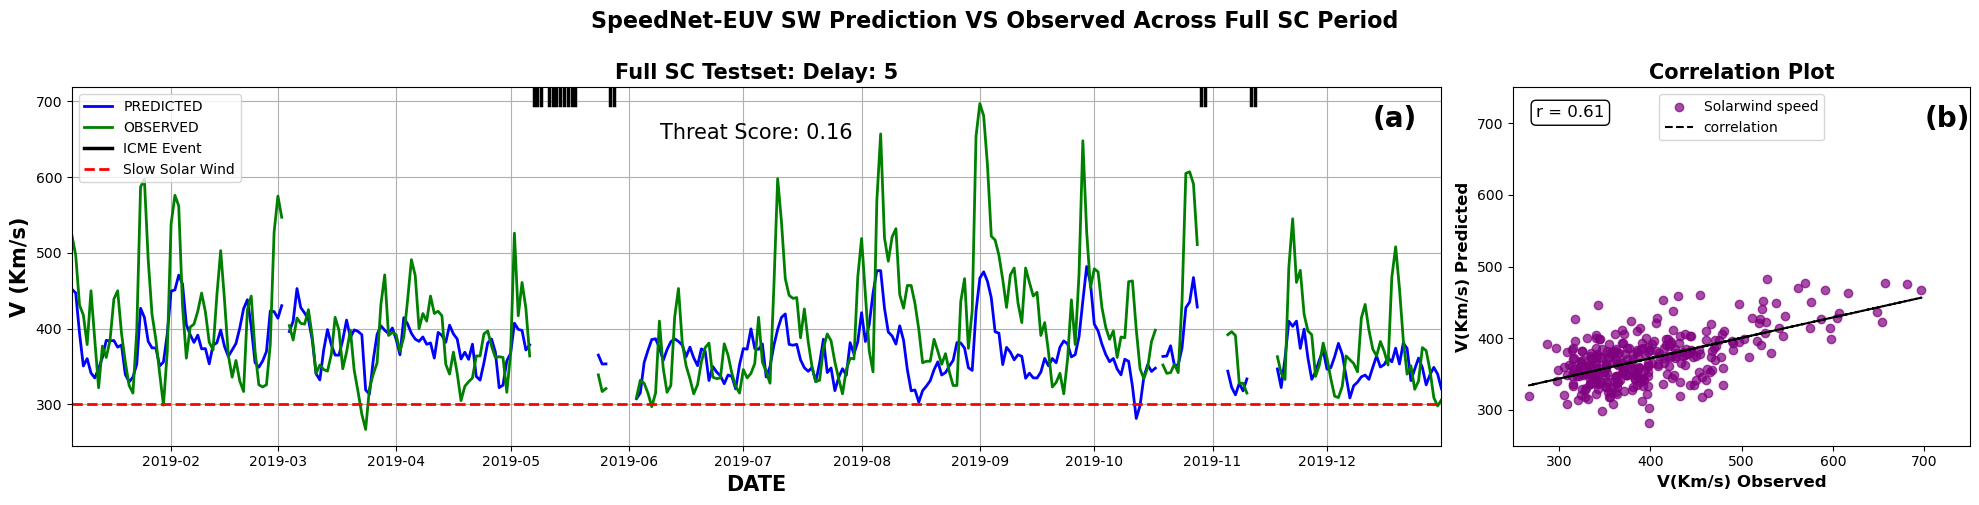

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [3, 1]})
# fig.tight_layout(pad=4.0)
        
plt.plot()
plt.style.use('default')

fig.suptitle(f"SpeedNet-EUV SW Prediction VS Observed Across Full SC Period", fontsize = 16, fontweight = "bold", y=1.0)

# FULL SC PERIOD

ax[0].plot(full_cycle_period_case_1['date'],full_cycle_period_case_1["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[0].plot(full_cycle_period_case_1['date'],full_cycle_period_case_1["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[0].set_title(f'Full SC Testset: Delay: {full_period_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[0].grid("on")
ax[0].text(0.5, 0.9, f'Threat Score: {full_2019_threat_score_case_1:.2f}', transform=ax[0].transAxes, fontsize=15,va='top', ha='center')
ax[0].text(0.95, 0.95, '(a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0].set_xlim(full_cycle_period_case_1['date'].iloc[0], full_cycle_period_case_1['date'].iloc[-1])
ax[0].legend(loc='upper left')

# Correlation plot in the 2019 Only
ax[1].scatter(full_cycle_period_case_1["test_original"], full_cycle_period_case_1["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_full_2019_SC_case_1, pred_cleaned_full_2019_SC_case_1, fitted_y_full_2019_SC_case_1, slope_full_2019_SC_case_1, intercept_full_2019_SC_case_1 = linear_fit(full_cycle_period_case_1)
ax[1].plot(obs_cleaned_full_2019_SC_case_1, fitted_y_full_2019_SC_case_1, color='black', linestyle='--', label="correlation")
ax[1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[1].text(0.05, 0.95, f"r = {full_corr_coef_2019_case_1:.2f}", transform=ax[1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[1].text(0.9, 0.95, '(b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1].set_xlim(250, 750)
ax[1].set_ylim(250, 750)
ax[1].legend(loc='upper center')



plt.subplots_adjust(top=0.7)
plt.subplots_adjust(hspace=0.5)
# # Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.savefig("Full_cycle_SpeedNet_EUV_prediction_with_correlation.png")
plt.show()


#### Quantitative Analysis of the Activation Map across HSS Peak Period (August 28 - September 05, 2019)

In [33]:
SN_list = []
Mean_list = []
max_list = []
min_list = []
Original_solar_wind = []
predicted_solar_wind = []
wind_date = []

# 4 days before/after the Peak
for i in range(len(Longer_HSS_full_period_selection)):
    Hss_full_period_img_cam, Hss_full_period_value = gradcamm(Longer_HSS_full_period_selection[i].reshape(1,256, 256, 3), best_model_full_period)
    SN_list.append(i+1)
    wind_date.append(list(full_period_Test_timeseries_date)[longer_HSS_full_period_indices_rand[i]+(full_period_num_delay+1)])
    Mean_list.append(np.mean(Hss_full_period_img_cam))
    max_list.append(np.max(Hss_full_period_img_cam))
    min_list.append(np.min(Hss_full_period_img_cam))
    Original_solar_wind.append(full_period_test_velocity_out[longer_HSS_full_period_indices_rand[i]])
    predicted_solar_wind.append(Hss_full_period_value)
    

case_1_activation_df = pd.DataFrame({
    'Map_index': SN_list,
    'Wind_date': wind_date,
    'Mean_act' : Mean_list,
    'Max_act': max_list,
    'Min_act': min_list,
    'Original_HSS': tf.squeeze(Original_solar_wind),
    'Predicted_HSS': tf.squeeze(predicted_solar_wind)
})
case_1_activation_df.to_csv('HSS_case_1_Gradcam_activation_metrics.csv')

In [34]:
case_1_activation_df.head()

Map_index              Wind_date  Mean_act   Max_act   Min_act  \
0          1  [2019-08-28 00:00:00]  1.721073  5.462944  0.345722   
1          2  [2019-08-29 00:00:00]  1.649246  5.579008  0.278324   
2          3  [2019-08-30 00:00:00]  1.663920  5.491210  0.012965   
3          4  [2019-08-31 00:00:00]  1.886778  7.608387  0.348716   
4          5  [2019-09-01 00:00:00]  1.917707  6.616185  0.096636   

   Original_HSS  Predicted_HSS  
0         466.0     374.252472  
1         374.0     348.414337  
2         424.0     344.844147  
3         654.0     423.171753  
4         697.0     466.654999

In [35]:
case_1_activation_df.tail()

Map_index              Wind_date  Mean_act   Max_act   Min_act  \
4          5  [2019-09-01 00:00:00]  1.917707  6.616185  0.096636   
5          6  [2019-09-02 00:00:00]  2.010328  6.006904  0.185709   
6          7  [2019-09-03 00:00:00]  2.127489  7.477694  0.192274   
7          8  [2019-09-04 00:00:00]  2.144054  6.388179  0.111434   
8          9  [2019-09-05 00:00:00]  1.981120  4.982655  0.215513   

   Original_HSS  Predicted_HSS  
4         697.0     466.654999  
5         681.0     474.986816  
6         616.0     462.457458  
7         522.0     440.781006  
8         517.0     395.852814